Exploratory Data Analysis (EDA): Emergency Department Wait-Time Measures

This section loads the CMS Timely and Effective Care – Hospital dataset and focuses on three ED timeliness measures (ED_1b, ED_2b, OP_18b). After cleaning column names and converting scores to numeric, we generate visualizations to better understand patterns in ED performance:

A histogram of OP_18b to examine the distribution of ED discharge wait times.

A boxplot comparing OP_18b scores across the top 10 states with the most reporting hospitals.

A correlation heatmap illustrating relationships among ED_1b, ED_2b, and OP_18b..

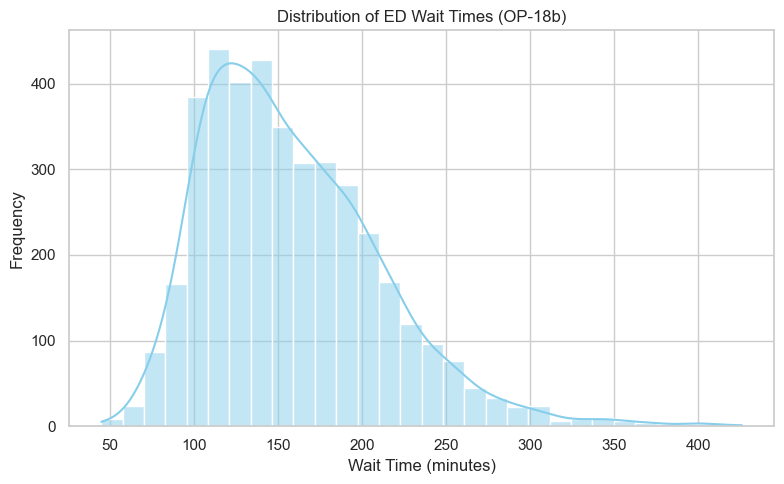

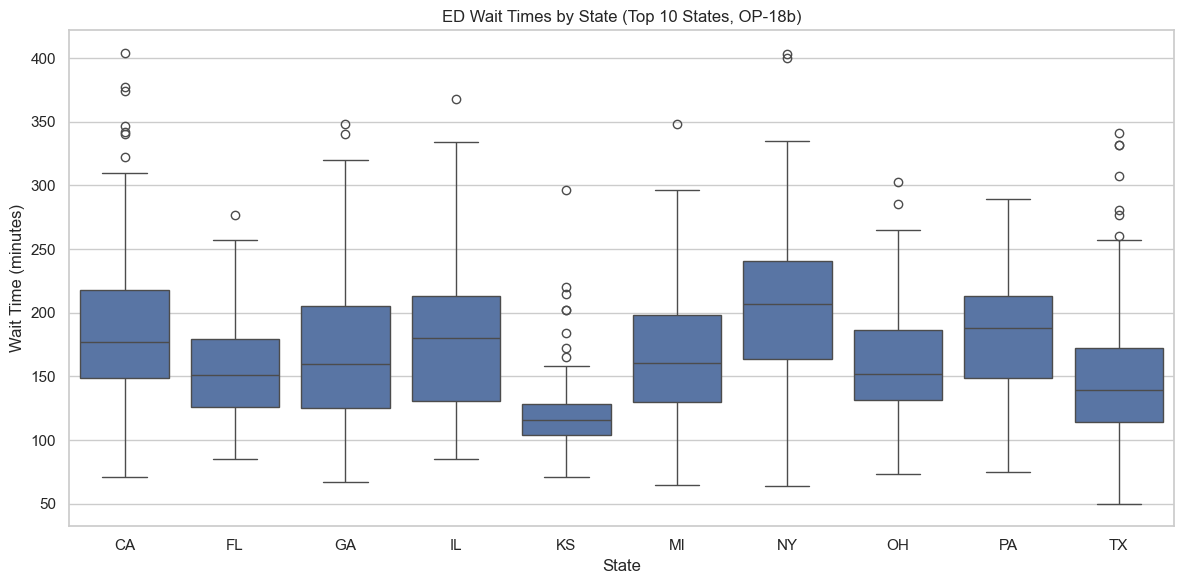

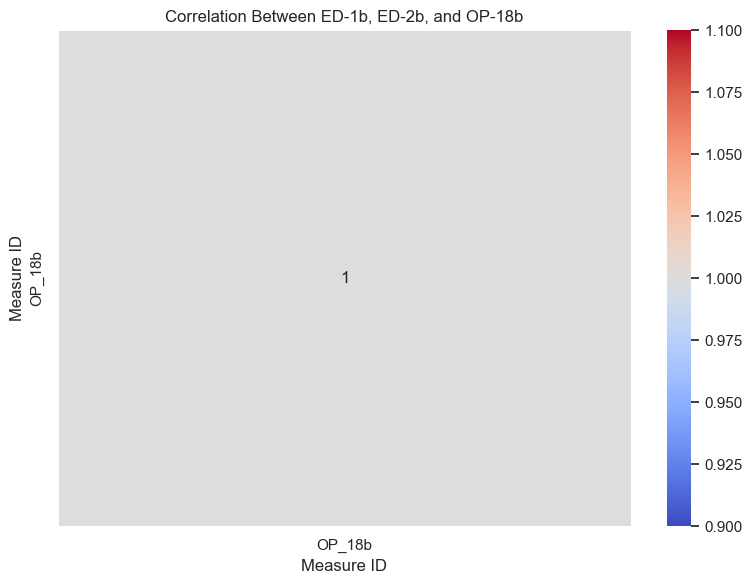

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Timely_and_Effective_Care-Hospital.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Focus on ED wait-time measures of interest
measures_of_interest = ['ED_1b', 'ED_2b', 'OP_18b']
df_filtered = df[df['Measure ID'].isin(measures_of_interest)]

# Pivot for correlation analysis
df_pivot = df_filtered.pivot_table(
    index='Facility ID',
    columns='Measure ID',
    values='Score',
    aggfunc='first'
).apply(pd.to_numeric, errors='coerce')

# Visualization style
sns.set(style="whitegrid")

# Histogram of OP-18b wait times
plt.figure(figsize=(8, 5))
op18b_scores = pd.to_numeric(
    df_filtered[df_filtered['Measure ID'] == 'OP_18b']['Score'],
    errors='coerce'
).dropna()
sns.histplot(op18b_scores, bins=30, kde=True, color='skyblue')
plt.title('Distribution of ED Wait Times (OP-18b)')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot by State (Top 10 states by reporting hospitals)
top_states = (
    df_filtered[df_filtered['Measure ID'] == 'OP_18b']['State']
    .value_counts()
    .head(10)
    .index.tolist()
)
df_box = df_filtered[
    (df_filtered['Measure ID'] == 'OP_18b') & 
    (df_filtered['State'].isin(top_states))
].copy()
df_box['Score'] = pd.to_numeric(df_box['Score'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Score', data=df_box)
plt.title('ED Wait Times by State (Top 10 States, OP-18b)')
plt.ylabel('Wait Time (minutes)')
plt.xlabel('State')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df_pivot.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between ED-1b, ED-2b, and OP-18b')
plt.tight_layout()
plt.show()


Modeling: Predicting ED Discharge Wait Time (OP_18b)

This cell builds a baseline Random Forest model to predict OP_18b (median ED wait time for discharged patients).
Steps: convert scores to numeric, select outpatient measures as predictors, pivot to facility-level wide format, remove incomplete rows (baseline), split train/test, fit the model, evaluate (MAE, RMSE, R²), and visualize Actual vs. Predicted.

Available Measure IDs: ['EDV' 'ED_2_Strata_1' 'ED_2_Strata_2' 'HCP_COVID_19' 'HH_01' 'HH_02'
 'IMM_3' 'OP_18b' 'OP_18c' 'OP_22' 'OP_23' 'OP_29' 'OP_31' 'OP_40'
 'SAFE_USE_OF_OPIOIDS' 'SEP_1' 'SEP_SH_3HR' 'SEP_SH_6HR' 'SEV_SEP_3HR'
 'SEV_SEP_6HR' 'STK_02' 'STK_03' 'STK_05' 'STK_06' 'VTE_1' 'VTE_2']
MAE: 65.44
RMSE: 65.44
R²: nan


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


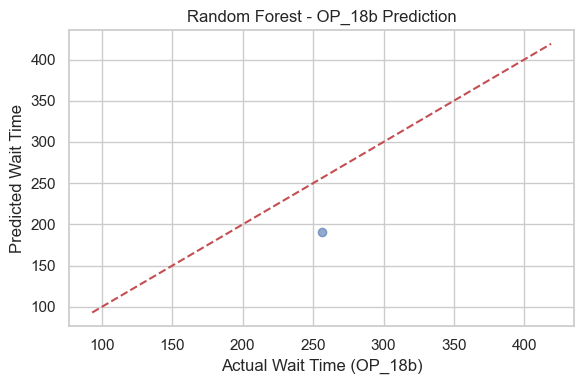

In [21]:


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Step 1: Convert Score to numeric
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')

# Step 2: Identify available measures
available_measures = df['Measure ID'].unique()
print("Available Measure IDs:", available_measures)

# Let's use a few that exist in your data (you confirmed OP_18b exists)
measures_to_use = ['OP_18b', 'OP_22', 'OP_23', 'OP_29', 'OP_31']  # adjust as needed

# Step 3: Filter and pivot the data
df_filtered = df[df['Measure ID'].isin(measures_to_use)]
df_pivot = df_filtered.pivot_table(index='Facility ID', columns='Measure ID', values='Score', aggfunc='mean').reset_index()

# Step 4: Drop rows with missing values
df_clean = df_pivot.dropna()

# Step 5: Define features and target
X = df_clean.drop(columns=['Facility ID', 'OP_18b'])
y = df_clean['OP_18b']

# Step 6: Split into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# Step 9: Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Wait Time (OP_18b)")
plt.ylabel("Predicted Wait Time")
plt.title("Random Forest - OP_18b Prediction")
plt.tight_layout()
plt.show()


### Measure Frequency Analysis  
To ensure model stability, we selected measures with sufficient reporting frequency. The chart below shows the top measures by record count, and we used those with more than 500 hospital reports (e.g., OP_18b, OP_22, OP_23).


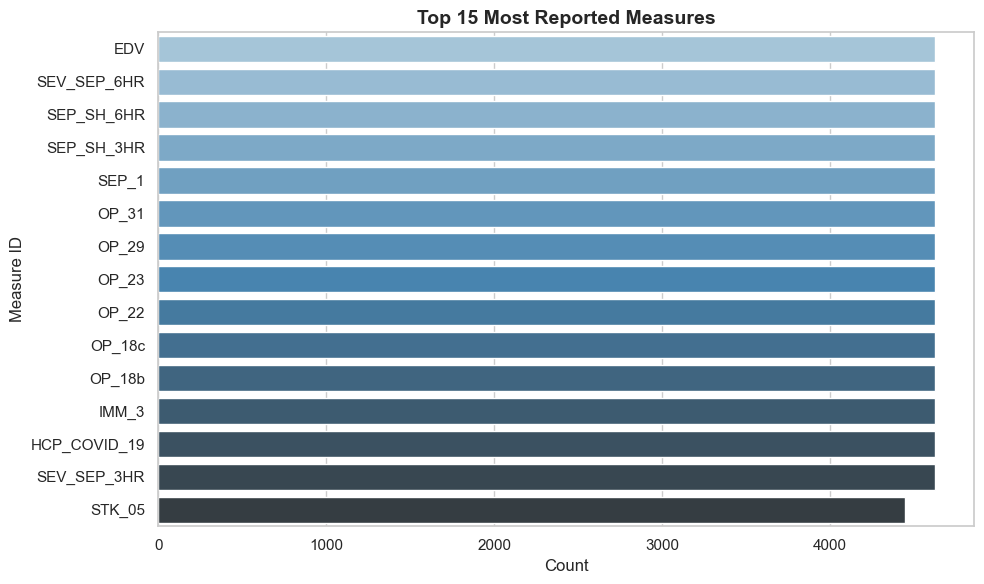

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(
    y=measure_counts.head(15).index, 
    x=measure_counts.head(15).values, 
    hue=measure_counts.head(15).index,   
    dodge=False, legend=False,          
    palette="Blues_d"
)

plt.title("Top 15 Most Reported Measures", fontsize=14, weight="bold")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Measure ID", fontsize=12)

plt.tight_layout()
plt.show()


Measure selection and data preparation

Select well-populated measures (OP_18b, OP_22, OP_29, OP_31), reshape the dataset to a facility-level table, convert scores to numeric, and drop incomplete rows. The result is a clean feature matrix X and target vector y with OP_18b as the prediction target.

In [29]:
# Choose better-populated measures
measures_to_use = ['OP_18b', 'OP_22', 'OP_29', 'OP_31']  # adjust if needed

# Filter to selected measures (copy to avoid SettingWithCopyWarning)
df_filtered = df.loc[df['Measure ID'].isin(measures_to_use)].copy()

# Ensure scores are numeric
df_filtered['Score'] = pd.to_numeric(df_filtered['Score'], errors='coerce')

# Pivot to facility-level wide format
df_pivot = (
    df_filtered
        .pivot_table(index='Facility ID', columns='Measure ID', values='Score', aggfunc='mean')
        .reset_index()
)

# Remove incomplete rows (baseline approach)
df_clean = df_pivot.dropna()

# Features and target
X = df_clean.drop(columns=['Facility ID', 'OP_18b'])
y = df_clean['OP_18b']

# Proceed with train-test split and modeling...


### Data Cleaning

We handle missing values by removing rows with incomplete measure scores.  
The print statements below show the dataset shape before and after cleaning, making the impact of `dropna()` transparent.


In [7]:
print("Before dropna:", df_pivot.shape)
print("After dropna:", df_clean.shape)


Before dropna: (4142, 6)
After dropna: (5, 6)


### Selecting Measures

We focus on a subset of performance measures relevant to emergency department efficiency, timeliness, and quality of care.  
The list below specifies the chosen measures for analysis and modeling.


In [8]:
measures_to_use = [
    'OP_18b', 'ED_1b', 'ED_2b', 'OP_22', 'OP_23',
    'OP_29', 'OP_31', 'OP_40', 'IMM_3', 'VTE_1', 'SEP_1'
]


### Data Filtering and Cleaning  

We filter the dataset to keep only the selected measures, reshape it into a facility–measure matrix, and remove facilities with missing values.  
This ensures the modeling dataset is complete and consistent.  


In [9]:
df_filtered = df[df['Measure ID'].isin(measures_to_use)]
df_pivot = df_filtered.pivot_table(index='Facility ID', columns='Measure ID', values='Score', aggfunc='mean').reset_index()
df_clean = df_pivot.dropna()
print("After dropna:", df_clean.shape)


After dropna: (0, 10)


### Measure Frequency Check  

Convert the **Score** column to numeric and count how many records exist for each measure.  
This helps identify which measures have the most complete data for modeling.  


In [10]:
df_check = df.copy()
df_check['Score'] = pd.to_numeric(df_check['Score'], errors='coerce')
measure_counts = df_check.groupby('Measure ID')['Score'].count().sort_values(ascending=False)
print(measure_counts)


Measure ID
IMM_3                  4241
OP_18b                 4035
OP_22                  3860
SAFE_USE_OF_OPIOIDS    3731
HCP_COVID_19           3488
SEP_1                  3089
SEV_SEP_3HR            3075
OP_18c                 3017
SEV_SEP_6HR            2947
OP_29                  2841
SEP_SH_3HR             2625
VTE_1                  2155
SEP_SH_6HR             2112
STK_02                 1650
OP_23                  1545
VTE_2                  1349
STK_06                 1313
STK_05                 1193
ED_2_Strata_1          1032
HH_01                   472
HH_02                   290
ED_2_Strata_2           281
STK_03                  179
OP_40                    57
OP_31                    17
EDV                       0
Name: Score, dtype: int64


### Selecting Key Measures  

Choose a subset of important measures (including OP_18b as the target) and reshape the dataset into a pivot table by **Facility ID**.  
Missing values are removed to prepare a clean dataset for modeling.  


In [11]:
measures_to_use = [
    'OP_18b',  # Target
    'IMM_3',
    'OP_22',
    'SAFE_USE_OF_OPIOIDS',
    'HCP_COVID_19',
    'SEP_1',
    'SEV_SEP_3HR',
    'OP_18c'
]

df_filtered = df[df['Measure ID'].isin(measures_to_use)]
df_pivot = df_filtered.pivot_table(index='Facility ID', columns='Measure ID', values='Score', aggfunc='mean').reset_index()
df_clean = df_pivot.dropna()

print("After dropna:", df_clean.shape)



After dropna: (2284, 9)


### Modeling and Evaluation  

We define **features (`X`)** and the **target (`y`)** where OP_18b is the target measure.  
The dataset is split into training and testing sets (80/20).  

A **Random Forest Regressor** is trained on the data, and predictions are made on the test set.  
Performance is evaluated using **MAE**, **RMSE**, and **R²**.  

Finally, we visualize predicted vs. actual wait times to assess model accuracy.  


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 27.87617067833698
RMSE: 37.00152427222791
R²: 0.48768766618442816


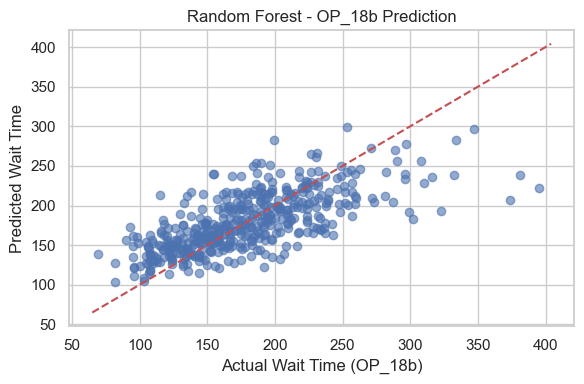

In [12]:
# Define features and target
X = df_clean.drop(columns=['Facility ID', 'OP_18b'])
y = df_clean['OP_18b']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Wait Time (OP_18b)")
plt.ylabel("Predicted Wait Time")
plt.title("Random Forest - OP_18b Prediction")
plt.tight_layout()
plt.show()


### Model Evaluation  

We evaluate model performance using the following metrics:  
- **Mean Absolute Error (MAE):** Average absolute difference between actual and predicted values.  
- **Root Mean Squared Error (RMSE):** Penalizes larger errors more strongly than MAE.  
- **R² (Coefficient of Determination):** Proportion of variance in the target explained by the model.  

The results are rounded for clarity.  


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Use squared=False for RMSE
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 4))


MAE: 27.88
RMSE: 37.0
R²: 0.4877


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Linear Regression Model  

We also train a **Linear Regression** model as a baseline for comparison.  

Steps:  
1. Fit the model on the training set.  
2. Predict values on the test set.  
3. Evaluate performance using:  
   - **MAE (Mean Absolute Error)** – average absolute prediction error.  
   - **RMSE (Root Mean Squared Error)** – emphasizes larger errors.  
   - **R² (Coefficient of Determination)** – proportion of variance explained.  

The results are printed for direct comparison with the Random Forest model.  


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print("MAE:", round(mae_lr, 2))
print("RMSE:", round(rmse_lr, 2))
print("R²:", round(r2_lr, 4))


Linear Regression Performance:
MAE: 31.12
RMSE: 41.31
R²: 0.3613


### Gradient Boosting Regressor  

We apply a **Gradient Boosting Regressor**, an ensemble method that builds trees sequentially, where each new tree corrects errors from the previous ones.  

Steps:  
1. Train the model on the training data.  
2. Predict on the test set.  
3. Evaluate performance using:  
   - **MAE (Mean Absolute Error)**  
   - **RMSE (Root Mean Squared Error)**  
   - **R² (Coefficient of Determination)**  

The printed metrics allow direct comparison with Linear Regression and Random Forest models.  


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)

# Evaluate
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor Performance:")
print("MAE:", round(mae_gb, 2))
print("RMSE:", round(rmse_gb, 2))
print("R²:", round(r2_gb, 4))


Gradient Boosting Regressor Performance:
MAE: 27.84
RMSE: 36.84
R²: 0.4923


### Training Gradient Boosting Regressor  

We initialize and train a **Gradient Boosting Regressor** using the training dataset (`X_train`, `y_train`).  
This ensemble model builds trees sequentially, with each tree learning from the residuals of the previous ones.  

```python
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)


### Feature Importance (Gradient Boosting)  
The plot shows which features contribute most to predicting ED wait times.  


C:\Users\hp\AppData\Local\Temp\ipykernel_43080\774201690.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='coolwarm')


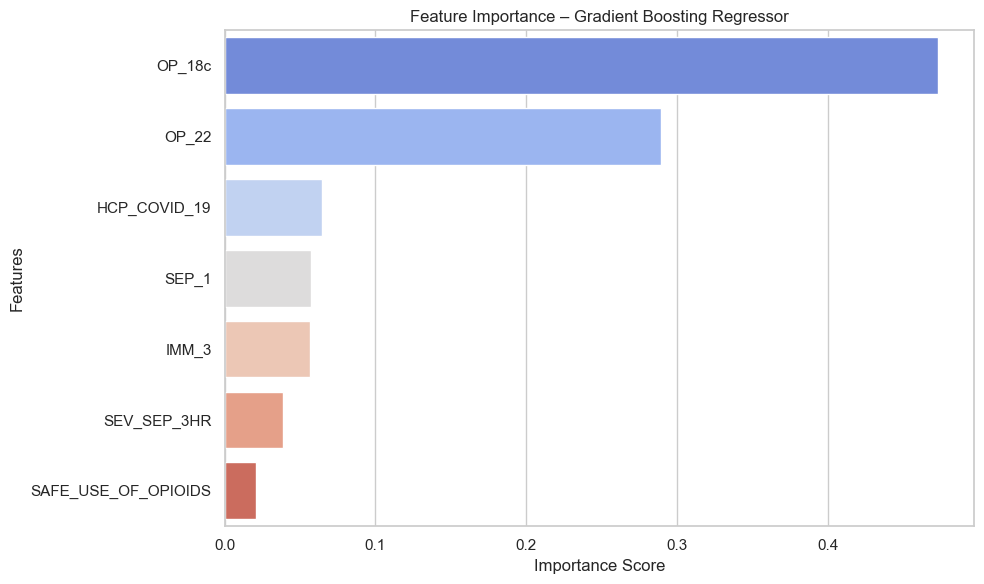

In [17]:
# Feature importance
feature_importance = pd.Series(gbr.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='coolwarm')
plt.title('Feature Importance – Gradient Boosting Regressor')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
